<div style="border:solid green 2px; padding: 20px">
    
Наталья, привет! Меня зовут Бунакова Влада. Если не возражаешь, предлагаю общаться на «ты» :)

Ниже в файле ты найдешь мои комментарии: <font color='green'>зеленый цвет — «все отлично»; </font> <font color='orange'>желтый — «хорошо, но можно лучше (один-два таких замечаний допустимы, но если их больше — придется исправлять)»; </font> <font color='red'>красный — «нужно исправить».</font> Комментарии в самом коде я отделяю знаками «###». Пожалуйста, не удаляй мои комментарии, они мне нужны при повторной проверке. Будет здорово, если в своих новых комментариях (выделяй их другим цветом) ты напишешь о сделанных тобой изменениях в коде. 


<div style="border:solid green 2px; padding: 20px">
Наталья, спасибо за доработки! Осталось одно замечание.

<div style="border:solid green 2px; padding: 20px">
Наталья, все ок, проект принимаю :)

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time  #подсчет времени обработки
import timeit

from sklearn.preprocessing import OrdinalEncoder #Кодирование категориальных функций
from sklearn.model_selection import train_test_split #Деление на выборки (тестовый набор данных)
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score #Оценит балл с помощью перекрестной проверки

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('/datasets/autos.csv')
display(df.head())

df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


### Вывод

Общая информация по стоблцам показало пустые значения в признаках. 

Нужно определится с тем, какие важные признаки мы берем для обучения модели и далее надо провести обработку для машинного обучения, в частности обработать строковые данные.

Выделим следующие признаки:
- VehicleType — тип автомобильного кузова. Тип кузова необходим для того чтобы определить предпочтения покупателя.
- RegistrationYear — год регистрации автомобиля. Чем больше возраст, тем меньше цена.
- Gearbox — тип коробки передач. Наличие автоматической коробки передач повышает стоимость машины.
- Power — мощность (лош.сила). важный критерий которая влияют на цену.
- Model — модель автомобиля. 
- Kilometer — пробег (км). Чем больше километров проехала машина, тем меньше цена.
- FuelType — тип топлива.
- Brand — марка автомобиля. Показывает качество и надежность автомобиля.
- NotRepaired — была машина в ремонте или нет. Влияет на стоимость машины.

Целевой признак:

- Price — цена (евро)


Создаем новый Датасет с нужными признаками

In [3]:
df = df[['VehicleType','RegistrationYear','Gearbox','Power','Model','Kilometer','FuelType','Brand','NotRepaired','Price']]
display(df.head())

print('Пропуски в признаках')
df.isna().sum()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,Price
0,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,480
1,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,18300
2,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,9800
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1500
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3600


Пропуски в признаках


VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
Price                   0
dtype: int64

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
    
Лишние признаки найдены верно. Стоило их отдельно перечислить :)    
</div>

Предобработка данных
1. Определение уникальных значений в признаках

In [4]:
def column_uniq(data):
    for r in data.columns.tolist():
        print(r)
        print(data[r].unique(),'\n')


In [5]:
column_uniq(df)

VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500] 

Gearbox
['manual' 'auto' nan] 

Power
[    0   190   163    75    69   102   109    50   125   101   105   140
   115   131    6

### Вывод

- VehicleType. Nan заполним как 'other'

- RegistrationYear. Некореектные годы регистрации.  Если учесть что год скачивания анкеты из базы 2016 год, поэтому последующие записи удалим.

- Gearbox. Nan заполним как 'manual'

- Power. Некорректные данные с мощностями. 

- Model. Nan заполним как 'other'

- FuelType. Nan заполним как 'other'

- NotRepaired. Nan заменим на 'yes'

2. Обрабатываем пропуски и некорректные данные.

In [6]:
df[ 'VehicleType'] = df['VehicleType'].fillna('other')
df[ 'Gearbox'] = df['VehicleType'].fillna('manual')
df[ 'Model'] = df['Model'].fillna('other')
df[ 'NotRepaired'] = df['NotRepaired'].fillna('yes')
df[ 'FuelType'] = df['FuelType'].fillna('other')

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Хорошо, пропуски заполнили.
</div>

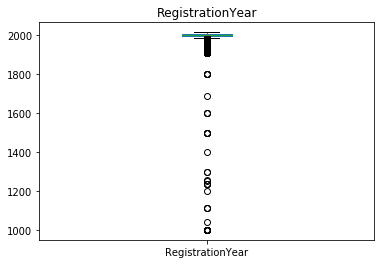

In [7]:
df = df.query('RegistrationYear<2017')
df['RegistrationYear'].plot.box()
plt.title('RegistrationYear')
plt.show()

Попробуем указать диапозон с 1945 по 2016

count    339600.000000
mean       2002.524046
std           6.840249
min        1946.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

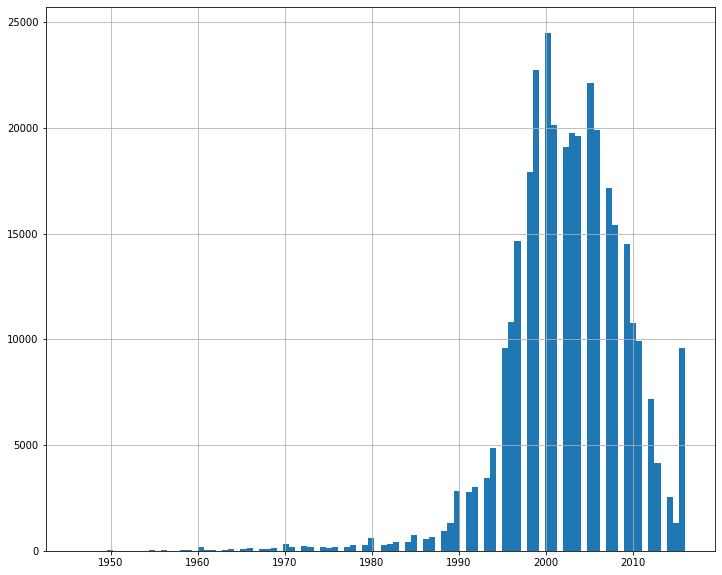

In [8]:
df = df.query('1945<RegistrationYear')
df['RegistrationYear'].hist(bins=100, figsize=(12,10))
df['RegistrationYear'].describe()

График показывавет, что можно указывать период с 1960 по 2016 годы. Собирём новый датасет

count    339229.000000
mean       2002.573250
std           6.679171
min        1961.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

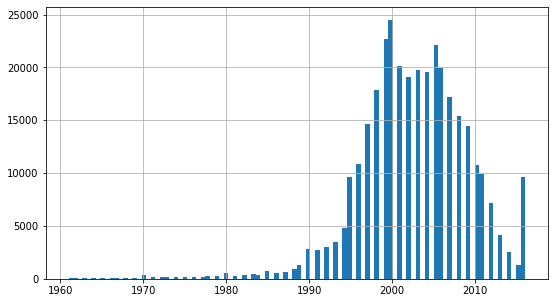

In [9]:
df = df.query('1960<RegistrationYear')
df['RegistrationYear'].hist(bins=100, figsize=(9,5))
df['RegistrationYear'].describe()

Боксплотом рассмотрим данные признака Power

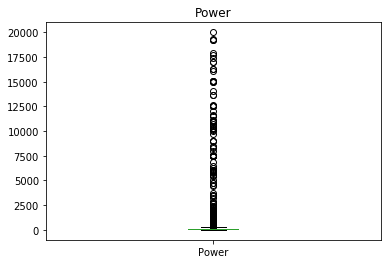

In [10]:
df['Power'].plot.box()
plt.title('Power')
plt.show()

Боксплот рекомендует использовать данные около 1000 л.с.

count    338953.000000
mean        107.813532
std          63.872714
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max        1000.000000
Name: Power, dtype: float64

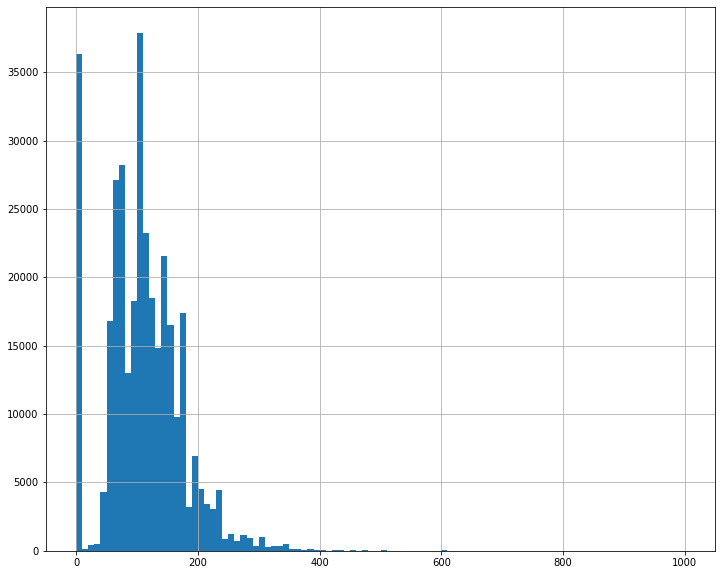

In [11]:
df = df.query('Power<1001')
df['Power'].hist(bins=100, figsize=(12,10))
df['Power'].describe()

На графике показывает что можно делать ещё отсечение данных в диапозоне 30 и 400

count    301507.000000
mean        120.372495
std          52.334568
min          31.000000
25%          75.000000
50%         111.000000
75%         150.000000
max         399.000000
Name: Power, dtype: float64

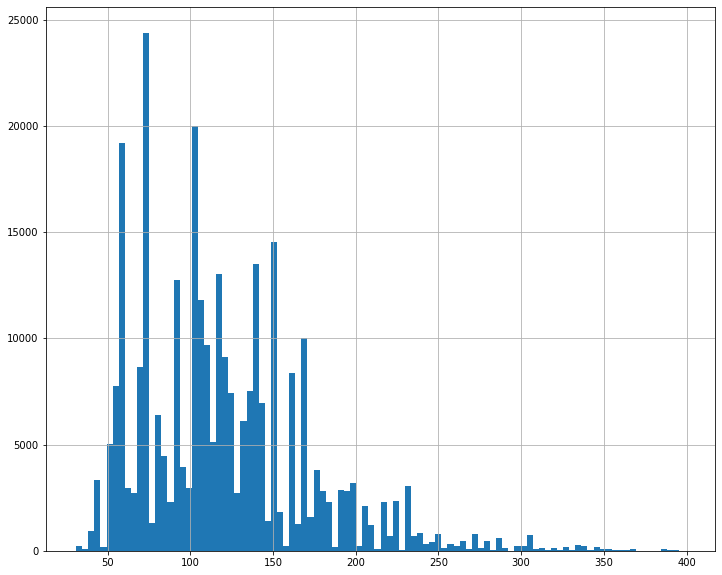

In [12]:
df = df.query('30<Power<400')
df['Power'].hist(bins=100, figsize=(12,10))
df['Power'].describe()

Удалим записи где цена авто равна нулю

count    295181.000000
mean       4844.105962
std        4601.028978
min           1.000000
25%        1340.000000
50%        3200.000000
75%        6990.000000
max       20000.000000
Name: Price, dtype: float64

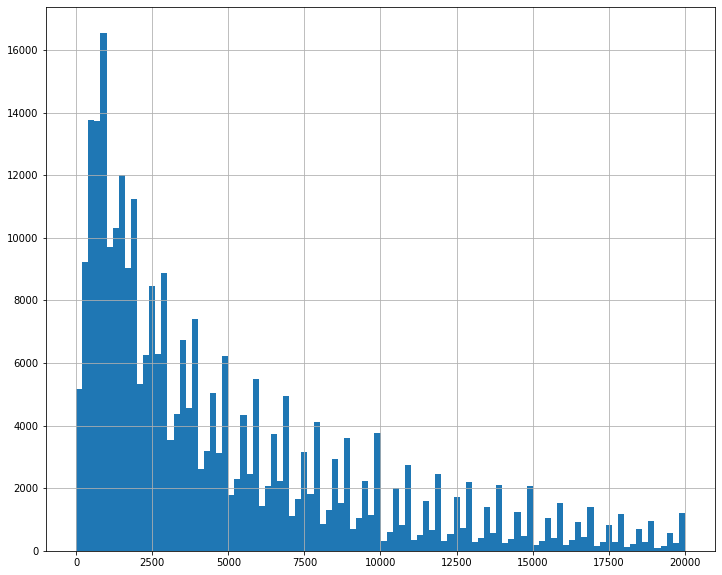

In [13]:
df = df.query('Price > 0')
df['Price'].hist(bins=100, figsize=(12,10))
df['Price'].describe()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295181 entries, 1 to 354368
Data columns (total 10 columns):
VehicleType         295181 non-null object
RegistrationYear    295181 non-null int64
Gearbox             295181 non-null object
Power               295181 non-null int64
Model               295181 non-null object
Kilometer           295181 non-null int64
FuelType            295181 non-null object
Brand               295181 non-null object
NotRepaired         295181 non-null object
Price               295181 non-null int64
dtypes: int64(4), object(6)
memory usage: 24.8+ MB


В датасете остаётся 295 181 записей. Далее необходимо строковые значения перевести в числовое обозначение.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Данные очищены от аномалий 👍
</div>

### Вывод

Предобработка данных завершена. Начинаем проводить обучение моделей

## Обучение моделей

попробуем сделать категориальное кодирование

- прямое кодирование
- OHE кодирование

In [15]:
original_df = df.drop('Price', axis=1)
target = df['Price']

#Прямое кодирование
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
cat_features = df[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
oe_features = original_df.copy()
for column in cat_columns:
    oe_features[column] = cat_features[column]

#OHE кодирование
ohe_features = pd.get_dummies(original_df, drop_first=True)

In [16]:
display(ohe_features.head())
display(oe_features.head())

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
1,2011,190,125000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,163,125000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,2001,75,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2008,69,90000,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
5,1995,102,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,2.0,2011,2.0,190,166.0,125000,2.0,1.0,1.0
2,6.0,2004,6.0,163,117.0,125000,2.0,14.0,1.0
3,5.0,2001,5.0,75,116.0,150000,6.0,38.0,0.0
4,5.0,2008,5.0,69,101.0,90000,2.0,31.0,0.0
5,4.0,1995,4.0,102,11.0,150000,6.0,2.0,1.0


<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера:</b> 
    
~~Для порядкового кодирования **набора** столбцов (а не одного столбца) предпочтительно использовать OrdinalEncoder()~~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
Поменяла метод кодирования. Сделала два способа кодирования, чтоб вызывать в обучении нужное.
</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>    
Хорошо!
    
Проще так:
    
    oe_features = original_df.copy()
    encoder = OrdinalEncoder()
    oe_features[cat_columns] = encoder.fit_transform(oe_features[cat_columns])
</div>

In [17]:
features_train, features_test, target_train, target_test = train_test_split(
    original_df, target, test_size=0.25, random_state=12345)

oe_features_train = oe_features.loc[features_train.index, :]
oe_features_test = oe_features.loc[features_test.index, :]

ohe_features_train = ohe_features.loc[features_train.index, :]
ohe_features_test = ohe_features.loc[features_test.index, :]

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Отлично, данные готовы для обучения.
</div>

Выберем следующие регрессоры для обучения модели:

- LinearRegression

- DecisionTreeRegressor

- CatBoostRegressor

- LGBMRegressor

<b>Линейная регрессия</b>

In [18]:
%%time

start_time = time.time()
model_LR = LinearRegression()
#model_LR.fit(features_train, target_train)
RMSE_LR = (cross_val_score(model_LR,ohe_features_train,target_train, cv=5, scoring='neg_mean_squared_error').mean() * -1) ** 0.5
stop_time = time.time()
time_LR = round(stop_time - start_time,3)
print('RMSE LinearRegression- ', RMSE_LR, ', time ', time_LR)

RMSE LinearRegression-  2562.9839521723643 , time  88.214
CPU times: user 1min 1s, sys: 26.6 s, total: 1min 28s
Wall time: 1min 28s


<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b> 
    
~~Для модели линейной регрессии (да и всех линейных моделей) категориальные признаки должны быть закодированы с помощью OHE-кодирования. Порядковое кодирование использовать некорректно, так как линейные модели используют арифметические операции над признаками.~~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
Вызвала OHE-кодирования.
</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Для остальных моделей, действительно, можно использовать порядковое кодирование.
</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
    
~~Зачем настраивать модель model_LR.fit(...) до вызова cross_val_score(..)? Это лишнее действие, которое увеличивает время работы кода. ~~ 
    
RMSE на кросс-валидации вычислено корректно.

</div>

<b>Регрессия DecisionTreeRegressor</b>

In [19]:
%%time

start_time = time.time()
model_DTR = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 'max_depth':max_depth_list, 'random_state':[12345]}]

 
clf = GridSearchCV(model_DTR, hyperparams, cv=5, scoring='neg_mean_squared_error')
clf.fit(oe_features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

RMSE_DTR = (max(means)*-1) ** 0.5
stop_time = time.time()
time_DTR = round(stop_time - start_time,3)
print('RMSE DecisionTreeRegressor- ', RMSE_DTR, ', time ', time_DTR)

{'criterion': 'mse', 'max_depth': 14, 'random_state': 12345}
3180.210476 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
2916.537783 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
2590.053041 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
2411.998303 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
2266.136178 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
2165.333678 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 12345}
2081.194710 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
2014.417299 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}
1958.271284 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 12345}
1918.689738 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 12345}
1890.322296 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 12345}
1870.608691 for {'criterion': 'mse', 'max_depth': 13, 'random_state': 12345}
1867.789890 for {'crite

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера:</b> 

~~1) Здесь и ниже при вызове GridSearchCV(...) указывай число блоков cv, чтобы все эксперименты проходили по одной схеме. Для линейной регрессии было cv=5.~~
    
~~2) Качество на кросс-валидации для модели с лучшими гиперпараметрами проще найти так:    
    clf.best_score_~~
</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Отлично, подобрали гиперпараметры для модели решающего дерева.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 

    cv=5.  +
     clf.best_score_  не смогла разобраться.    
</div>

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера v2:</b>    
    
~~Для модели решающего дерева предпочтительнее использовать **порядковое** кодирование категориальных признаков. Из-за большого числа признаков при OHE-кодировании модель будет работать медленнее и менее эффективно.~~ 
    
~~Как вариант, можно построить модели как для OHE, так и для порядкового кодирования, и сравнить результаты. Но это по желанию :)~~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента v2:</b> 
Дейсвительно обработка моментальная, спасибо. )
Не стала два способа выкладывать и чтоб ждать долгой обработки. Но я честно увидела разницу )
</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>    

Извини, комментарий насчет best_score_ должен был быть все-таки зеленым, а не желтым. Я имела в виду то, что качество на кросс-валидации для лучшего набора гиперпараметров (RMSE_DTR) можно найти всего в одну строчку, не обращаясь ко всем полученным результатам clf.cv_results_: после вызова
    
    clf = GridSearchCV(model_DTR, hyperparams, cv=5, scoring='neg_mean_squared_error')
    clf.fit(...)
    
в clf.best_score_ хранится значение scoring (то есть 'neg_mean_squared_error' в данном случае) для лучшего набора гиперпараметров (clf.best_params_). 
</div>


<b>Регрессия CatBoostRegressor</b>

In [20]:
%%time

start_time = time.time()
model_CBR = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8], 'random_state':[12345], 'verbose':[False]}]

clf = GridSearchCV(model_CBR, hyperparams, cv=5, scoring='neg_mean_squared_error')
clf.fit(oe_features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

RMSE_CBR = (max(means)*-1) ** 0.5
stop_time = time.time()
time_CBR = round(stop_time - start_time,3)
print('RMSE CatBoostRegressor- ', RMSE_CBR, ', time ', time_CBR)

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
1607.880057 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
1575.455416 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
1602.021789 for {'learning_rate': 0.8, 'random_state': 12345, 'verbose': False}

RMSE CatBoostRegressor-  1575.4554161270119 , time  2638.246
CPU times: user 24min 21s, sys: 3min 33s, total: 27min 55s
Wall time: 43min 58s


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Моделям CatBoostRegressor и LGBMRegressor можно передавать список категориальных признаков. Также для данных моделей категориальные признаки можно не кодировать, а использовать внутреннее кодирование моделей. Как это отразится на качестве? Можно поэкспериментировать :) 
</div>

<b>Регрессия LGBMRegressor</b>

In [21]:
%%time

start_time = time.time()
model_LGBM = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 'learning_rate':[0.1, 0.3, 0.5], 'random_state':[12345]}]

clf = GridSearchCV(model_LGBM, hyperparams, cv=5, scoring='neg_mean_squared_error')
clf.fit(oe_features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

RMSE_LGBM = (max(means)*-1) ** 0.5
stop_time = time.time()
time_LGBM = round(stop_time - start_time,3)
print('RMSE LGBMRegressor- ', RMSE_LGBM, ', time ', time_LGBM)

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}
1692.908075 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 12345}
1609.295960 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 12345}
1578.101831 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}
1633.015982 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 12345}
1579.169671 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 12345}
1567.287253 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}
1632.943193 for {'learning_rate': 0.5, 'num_leaves': 31, 'random_state': 12345}
1599.726978 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 12345}
1600.543775 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 12345}

RMSE LGBMRegressor-  1567.287252900132 , time  758.374
CPU times: user 10min 27s, sys: 4.08 s, total: 10min 31s
Wall time: 12min 38s


<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера v2:</b> 
    
~~Здесь тоже надо задать cv=5.~~
</div>


<div class="alert alert-block alert-info">
<b>Комментарий студента v2:</b> 
+
</div>

### Вывод

Получилось зафикисровать лучшие параметры обучения. Впереди проверка на тестовой выборке с лучшими гиперпараметрами

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Прекрасно, переходим к следующему шагу.
</div>

## Анализ моделей

In [22]:
%%time

start_time = time.time()
model = LinearRegression()
model.fit(ohe_features_train, target_train)
stop_time = time.time()
time_LR_train = round(stop_time - start_time,3)

CPU times: user 17.6 s, sys: 11 s, total: 28.6 s
Wall time: 42 s


In [23]:
%%time

start_time = time.time()
predict = model.predict(ohe_features_test)
RMSE_LR_test = mean_squared_error(target_test, predict) ** 0.5
stop_time = time.time()
time_LR_test = round(stop_time - start_time,3)
print('RMSE LinearRegression ', RMSE_LR_test, ', time ', time_LR_test)

RMSE LinearRegression  2545.099329787855 , time  0.227
CPU times: user 102 ms, sys: 154 ms, total: 256 ms
Wall time: 288 ms


In [24]:
%%time

start_time = time.time()
model = DecisionTreeRegressor(criterion='mse', max_depth=14,  random_state=12345) 
model.fit(oe_features_train, target_train)
stop_time = time.time()
time_DRT_train = round(stop_time - start_time,3)

CPU times: user 744 ms, sys: 3.67 ms, total: 748 ms
Wall time: 3.4 s


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Чтобы вручную не переписывать гиперпараметры лучших моделей можно использовать
    
    model=clf.best_estimator_
    
где clf – из раздела «Регрессия DecisionTreeRegressor».
</div>

In [25]:
%%time

start_time = time.time()

predict = model.predict(oe_features_test)
RMSE_DTR_test = mean_squared_error(target_test, predict) ** 0.5
stop_time = time.time()
time_DTR_test= round(stop_time - start_time,3)
print('RMSE DecisionTreeRegressor ', RMSE_DTR_test, ', time ', time_DTR_test)

RMSE DecisionTreeRegressor  1836.5201192742218 , time  0.016
CPU times: user 13.9 ms, sys: 3.57 ms, total: 17.5 ms
Wall time: 15.9 ms


In [26]:
%%time

start_time = time.time()
model = CatBoostRegressor(learning_rate=0.5, random_state=12345, verbose=False) 
model.fit(oe_features_train, target_train)
stop_time = round(stop_time - start_time,3)
time_CBR_train = time.time() - start_time

CPU times: user 1min 50s, sys: 19.6 s, total: 2min 10s
Wall time: 3min 51s


In [27]:
%%time

start_time = time.time()
predict = model.predict(oe_features_test)
RMSE_CBR_test = mean_squared_error(target_test, predict) ** 0.5
stop_time = time.time()
time_CBR_test= round(stop_time - start_time,3)
print('RMSE CatBoostRegressor ', RMSE_CBR_test, ', time ', time_CBR_test)

RMSE CatBoostRegressor  1555.1741647041574 , time  0.302
CPU times: user 109 ms, sys: 28.7 ms, total: 137 ms
Wall time: 303 ms


In [28]:
%%time

start_time = time.time()
model = LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=19072020)
model.fit(oe_features_train, target_train)
stop_time = round(stop_time - start_time,3)
time_LGBM_train = time.time() - start_time

CPU times: user 16 s, sys: 248 ms, total: 16.3 s
Wall time: 21.9 s


In [29]:
%%time

start_time = time.time()
target_predict = model.predict(oe_features_test)
RMSE_LGBM_test = mean_squared_error(target_test, target_predict) ** 0.5
stop_time = time.time()
time_LGBM_test= round(stop_time - start_time,3)
print('RMSE LGBMRegressor ', RMSE_LGBM_test, ', time ', time_LGBM_test)

RMSE LGBMRegressor  1542.512677979484 , time  0.897
CPU times: user 639 ms, sys: 0 ns, total: 639 ms
Wall time: 898 ms


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Время обучения и предсказания вычисляются корректно.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера:</b> 
    
~~Время обучения и предсказания лучше сохранять в отдельные переменные, чтобы использовать их ниже для внесения в таблицу. Для этого можно использовать time.time().~~
    
    
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
 
  спасибо за наводку, а то я в ручную мучалась :)
    
</div>

<b>Рейтинг моделей:</b>

In [30]:
index = ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor', 'LGBMRegressor']

data = {'RMSE на обучающей выборке, евро':[RMSE_LR, RMSE_DTR, RMSE_CBR, RMSE_LGBM],
        'Время подбора гиперпараметров, сек':[time_LR, time_DTR, time_CBR, time_LGBM],
        'RMSE на тестовой выборке, евро':[RMSE_LR_test, RMSE_DTR_test, RMSE_CBR_test, RMSE_LGBM_test],
        'Время обучения модели, сек':[time_LR_train, time_DRT_train, time_CBR_train, time_LGBM_train],
        'Время предсказания модели, сек':[time_LR_test, time_DTR_test, time_CBR_test, time_LGBM_test]}

stat = pd.DataFrame(data=data, index=index)

for i, r in stat.iterrows():
    stat.loc[i,'Рейтинг RMSE'] = stat['RMSE на обучающей выборке, евро'].min()/r['RMSE на обучающей выборке, евро']
    stat.loc[i,'Рейтинг времени обучения'] = stat['Время обучения модели, сек'].min() / r['Время обучения модели, сек']
    stat.loc[i,'Рейтинг времени предсказания'] = stat['Время предсказания модели, сек'].min() / r['Время предсказания модели, сек']
    stat.loc[i,'Итоговый рейтинг'] = stat.loc[i,'Рейтинг RMSE'] + stat.loc[i,'Рейтинг времени обучения'] + stat.loc[i,'Рейтинг времени предсказания']

display(stat)

,"RMSE на обучающей выборке, евро","Время подбора гиперпараметров, сек","RMSE на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,2562.983952,88.214,2545.099330,41.993000,0.227,0.611509,0.080966,0.070485,0.762959
DecisionTreeRegressor,1867.789890,320.558,1836.520119,3.400000,0.016,0.839113,1.000000,1.000000,2.839113
CatBoostRegressor,1575.455416,2638.246,1555.174165,231.404923,0.302,0.994815,0.014693,0.052980,1.062488
LGBMRegressor,1567.287253,758.374,1542.512678,21.890313,0.897,1.000000,0.155320,0.017837,1.173157


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Таблица замечательная! 
    
~~Вместо «Время обучения» ты имеешь в виду «Время подбора гиперпараметров»?~~
    
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
 
  да наверное лучше так написать, а то получается два одинаковых предназначения столбцов. Исправила :)
    
</div>


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>    
    
~~Поясни, почему в таблице время обучения модели решающего дерева равно нулю?~~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента v2:</b> 
 
   подсчет был не верно прописан. Исправила
    
</div>

### Вывод

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать DecisionTreeRegressor, т.к у этой модели все три показателя находятся в пределах среднего значения. Т.е стабильно держит среднее качество, скорость и время. Сочетания скорости и точности на подготовленных данных выводит его в лидеры рейтинга. 

Если рассматривать только оценивание точности, то в лидеры выходит LGBMRegressor. Следом за ним идет CatBoostRegressor, DecisionTreeRegressor на третьем месте.

Лучше всего время обучения у LinearRegression

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Ок, хорошо.    
    
~~Модель LGBMRegressor в лидерах не только по значению RMSE, но и по времени предсказания.~~
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера v3:</b>    
Выводы стоило обновить.
</div>


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

<div style="border:solid green 2px; padding: 20px">
Наталья, ты провела очень качественное исследование, молодец! Предобработка данных выполнена безупречно, доработать нужно лишь раздел с обучением моделей:
    
- провести OHE-кодирование категориальных признаков для модели линейной регрессии;
- исправить желтые замечания (их должно быть не больше двух).

<div style="border:solid green 2px; padding: 20px">
Наталья, спасибо! Осталось исправить одно замечание насчет выбора кодирования для модели решающего дерева.

<div style="border:solid green 2px; padding: 20px">
Наталья, отличная работа! 👍

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей